## Bigram Language Model

In this notebook we will be implementing a bigram language model. A language bigram model is a model that predicts the next character based on the previous character. For example, if we have the sentence "I am a", the bigram model will predict the next character based on the last character of the sentence. In this case, the bigram model will predict the next character based on the last character "a". The bigram model will predict the next character to be " " (space) with a probability of 0.5 and "s" with a probability of 0.5.

![alt text](image/bigram.png "Title")


## Data Exploration
What I have today is the names dataset. It is a simple list of 32K names. And as a goal of this exercise, I want you to generate new names for kids that you might have in the future (or not).

In [17]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

Now, let's start looking at the bigram. 

In [18]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a


**NOTE**: We have more information in this word "Emma" than the three examples listed above. Can you figure out what it is?

Question: Can you print all the different combinations that we can have with the letters in the word "Emma"?

In [ ]:
%load answers/load_emma.py

Question: Can you now make a lookup table for all the words?

In [19]:
%load answers/complete_bigram.py

As we all know, ML is just statistics. So lets count the number of times each combination of characters appear in the dataset.

In [25]:
# Hide the code

In [26]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

## DATA PREPARATION
We explored the dataset now it's time to prepare the data for modelling. We will not use tensor to store the data rather than the python dictionary.

We want to create a 2D tensor, where each row will be a character and each column representing the number of times that character in the column appears after the character in the row.

In [28]:
import torch
N = torch.zeros((28, 28), dtype=torch.int32)

In [43]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27
itos = {i:s for s,i in stoi.items()}

In [45]:

for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1
    

In [46]:
N

tensor([[  556,  4951,  1776,  2584,  2382,  1665,   585,  3001,  2524,   766,
          2990,  5491,  3206,  7976,  1209,   476,   575,  3356,  2757,  2742,
          1689,   912,   537,   489,  2184,   970,   929,  6640],
        [ 6961,  1706,  1624,  1475,  3781,  2076,   402,   545,  7213,  4951,
           525,  1807,  7584,  4906, 16419,   189,   246,  1022,  9800,  3356,
          2106,  1143,  2502,   483,   629,  6150,  1305, 13394],
        [  929,   963,   156,     4,   746,  1965,     2,   664,   394,   654,
           319,   116,   309,     0,   392,   316,    11,    76,  2531,    59,
            41,   135,     0,     3,   104,   253,     0,   325],
        [ 1400,  2446,     3,   275,  1286,  1658,    25,   124,  2666,   822,
            12,  1008,   378,    31,   378,  1140,     4,   457,   257,    19,
           197,   122,    23,     0,   326,   313,    12,   710],
        [ 1195,  4030,   156,   393,  1718,  3931,   140,   227,  1172,  2077,
           205,  3257,   

This is an ugly mess, lets visualize it better.

(-0.5, 27.5, 27.5, -0.5)

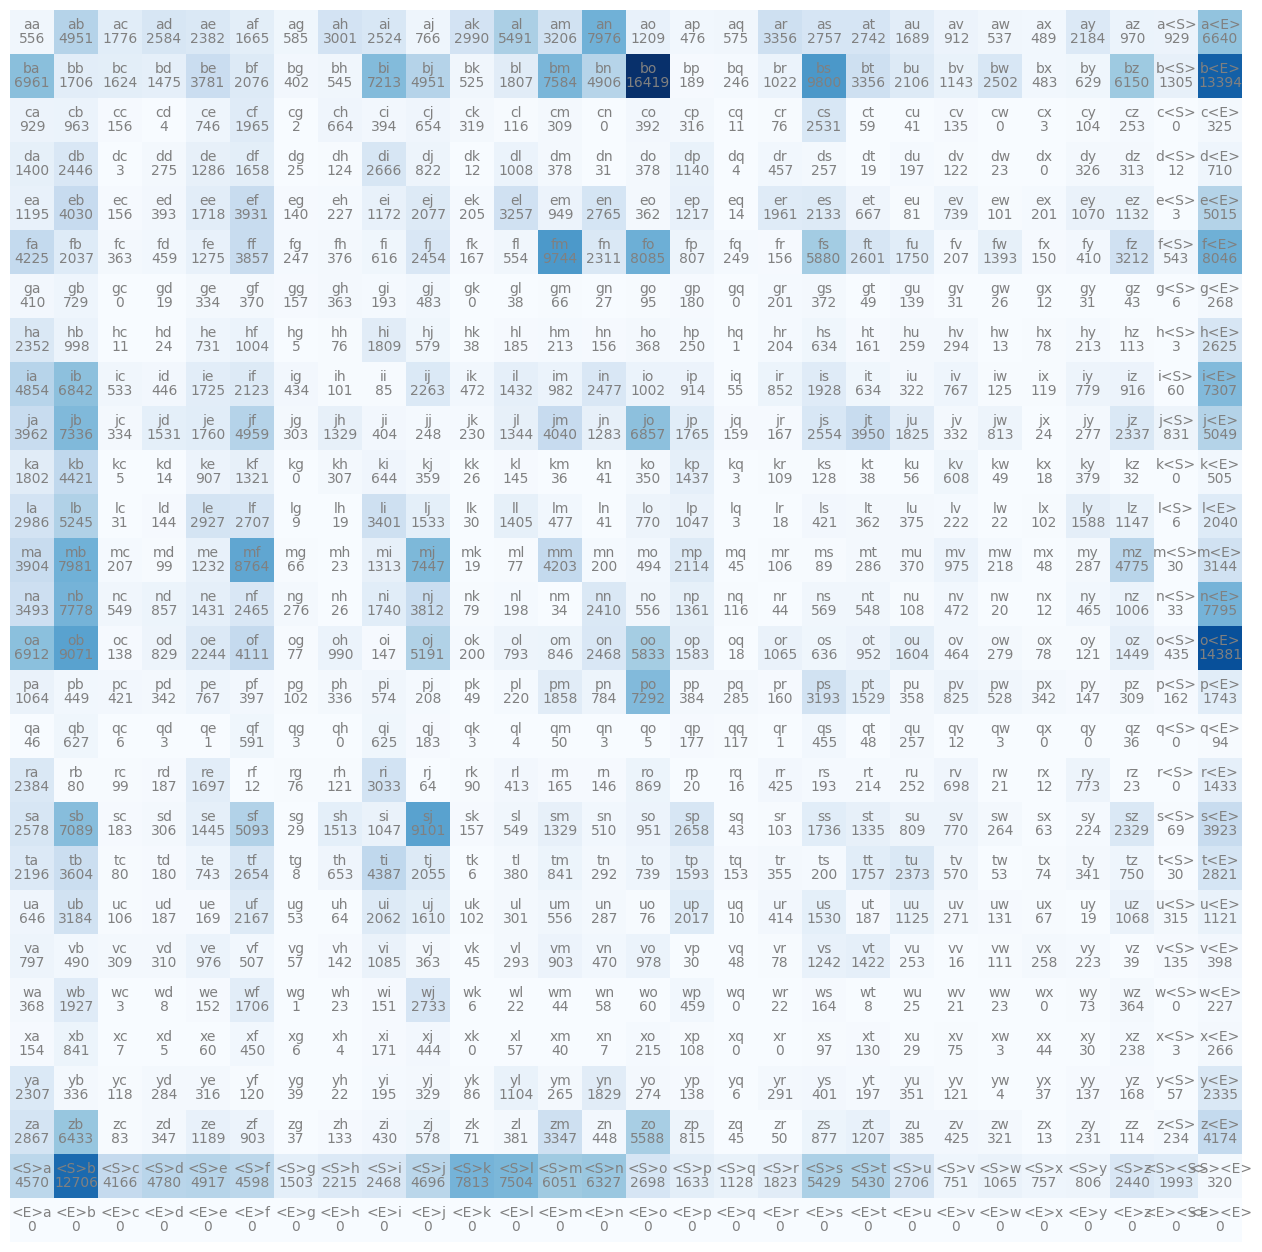

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

### Lets visualize it better

I dont want sepeate start and end characters in the visualization. So I will remove them from the dictionary.

In [52]:
N = torch.zeros((27, 27), dtype=torch.int32)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

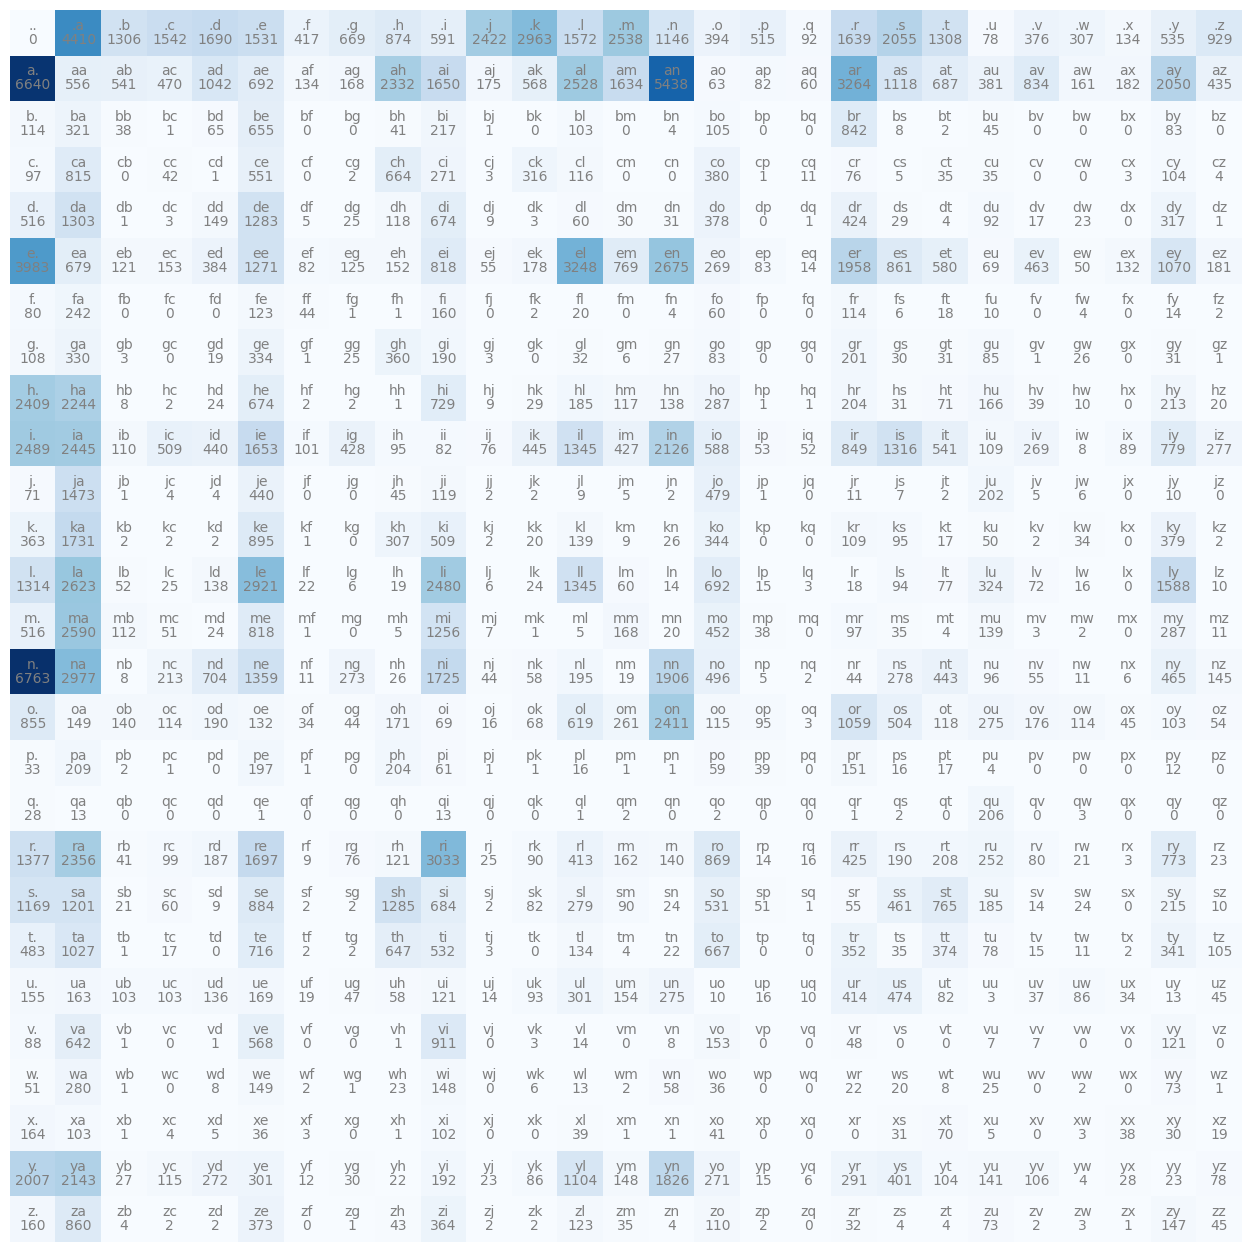

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [57]:
# How many times each character appears at the beginning of a name
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [74]:
# Convert to probabilities
P = N[0].float()
P = P / p.sum()
P

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])

In [68]:
#NOTE(self): Run it multiple times
g = torch.Generator().manual_seed(1337)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.0654, 0.4140, 0.5205])

In [71]:
# Demo of multinomial
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2])

#### Going back to our original problem

In [76]:
# To generate psuedo-random numbers the same way every time
g = torch.Generator().manual_seed(1337)
# Multinomial sampling is just like you give me a list of probabilities
#  and I'll give you a number based on those probabilities
ix = torch.multinomial(P, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'm'

In [20]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

#### Lets look at our first result

In [88]:
g = torch.Generator().manual_seed(1337)

ix = 0
while True:
    p = N[ix]
    p = p / p.sum()
    ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
    print(itos[ix])
    if ix == 0:
        break


m
y
l
i
e
n
a
.


In [90]:
g = torch.Generator().manual_seed(1337)

for _ in range(10):
    out = []
    ix = 0
    while True:
        p = N[ix].float()
        p = p / p.sum()
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        # print(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

myliena.
r.
a.
ahi.
grammian.
n.
xxonh.
chaldeiniy.
bler.
jaranige.


In [91]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [92]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


In [93]:
# If the model has not learned anything, the probability of each character
1/27

0.037037037037037035

In [94]:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2].item()
        print(f'{ch1} -> {ch2} : {prob:.3f}')

. -> e : 0.048
e -> m : 0.038
m -> m : 0.025
m -> a : 0.389
a -> . : 0.196
. -> o : 0.012
o -> l : 0.078
l -> i : 0.177
i -> v : 0.015
v -> i : 0.351
i -> a : 0.138
a -> . : 0.196
. -> a : 0.138
a -> v : 0.025
v -> a : 0.247
a -> . : 0.196


This means that the model has learned something, but not much.

Now, lets move back to our original problem.